# Load libraries needed

In [1]:
#Pandas
import pandas as pd
from pandas import ExcelWriter, ExcelFile

#Numpy
import numpy as np

#Seaborn
import seaborn as sns

#NLTK
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
stop = stopwords.words('english')

#SkLearn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif

#Other
import string
import warnings
#Tons of pink warnings about "version changes" just ignoring them
warnings.filterwarnings("ignore")

#Word Cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('txpl_project_updated.xlsx')

# Cute Word Cloud

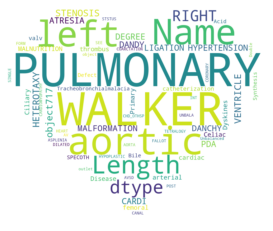

In [2]:
data = df.dropna(subset=['CHD_OTHSP','SPECOTH','SURGERY_HISTORY'])

# Start with one review:
text = str(data.CHD_OTHSP) + str(data.SPECOTH) + str(data.SPECOTH)
heart_mask = np.array(Image.open("silhouette-of-a-heart-3.png"))
                    
wordcloud = WordCloud(mask=heart_mask,background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear",)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [3]:
#Check to make sure we have the columns and it imported 
print(df.columns)

#The categorical variables needed to one hot encode
cat_var = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']] 

#Do not want to hot encode these.  
cat_var.remove('CHD_OTHSP')
cat_var.remove('SPECOTH')
cat_var.remove('SURGERY_HISTORY')

#show the categorical
print(cat_var)

Index(['AGE_LISTING', 'AGE_TXPL', 'STATLIST', 'SLVAD', 'SLECMO', 'SLVENT',
       'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI',
       ...
       'TXHDL_R', 'TXVLDL_R', 'eGFR_TXPL', 'GRAFT_LOSS', 'INT_GRAFT_LOSS',
       'SURGERY_HISTORY', 'SV_GROUP', 'LSNYHA_T', 'LSRHFCL_T', 'PATIENT_ID'],
      dtype='object', length=197)
['STATLIST', 'SLINODS', 'SEX', 'TXSTAT', 'DONORSEX', 'STATUS_LISTING', 'STATUS_TXPL', 'LSNYHA_T', 'LSRHFCL_T']


# Prepare Data 

In [4]:
#This unnamed column gets added as an index from importing with pandas, not sure how to drop it in the 
#import so just dropping it here
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

#Looking at the data specs
print(df.shape)
print(df.head())
print(df.describe())

(6871, 197)
   AGE_LISTING   AGE_TXPL STATLIST  SLVAD  SLECMO  SLVENT  HXARRYTH  HXCPR  \
0    15.855219  16.046873        1    0.0     0.0     0.0       1.0    NaN   
1     5.065128   5.100721        1    0.0     0.0     0.0       0.0    NaN   
2     9.089851   9.278767        2    0.0     0.0     0.0       0.0    NaN   
3     0.722807   1.136231        2    0.0     0.0     0.0       0.0    NaN   
4     3.980917   4.115074        2    0.0     0.0     0.0       0.0    NaN   

   HXDIAB  HXGI  ...  TXHDL_R  TXVLDL_R   eGFR_TXPL  GRAFT_LOSS  \
0     0.0   0.0  ...      NaN       NaN   81.049908           1   
1     0.0   0.0  ...      NaN       NaN  123.889262           0   
2     0.0   0.0  ...      NaN       NaN  135.244903           1   
3     0.0   0.0  ...      NaN       NaN   71.254683           1   
4     0.0   1.0  ...      NaN       NaN   61.262768           1   

   INT_GRAFT_LOSS                        SURGERY_HISTORY  SV_GROUP  \
0        2.965153  Physician Reported No Other

In [5]:
#One hot encode everything
df_processed = pd.get_dummies(df, prefix_sep="_",columns=cat_var)

#Text variables to drop from the first model
text = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] in ['object']] 

#These are the text variables now because we transformed the others
print(text)

#Storing all continuous variables
con_var = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] not in ['object']] 

#We don't want this in any of the models, it's useless information
con_var.remove('PATIENT_ID')

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_processed['GRAFT_LOSS'].value_counts())

#Set to only heterotaxy
df_filtered_list = df_processed[df_processed['SV_GROUP'] == 1]

#I'm just filtering above to see different numbers for testing
print(df_processed.shape)
print(df_filtered_list.shape)

['SPECOTH', 'CHD_OTHSP', 'SURGERY_HISTORY']
0    5206
1    1665
Name: GRAFT_LOSS, dtype: int64
(6871, 222)
(1803, 222)


In [6]:
#Model without text fields
#Drop the text fields
df_model1 = df_filtered_list.drop(text,axis=1)

In [7]:
df_model1

#Look at missing
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

# #This is an issue
# missing(df_model1)

#Eliminate missing data that is more than 20%
filter_missing = df_model1[df_model1.columns[df_model1.isnull().mean() < 0.25]]

missing(filter_missing)




LSSAB_R                    24.68
TXICU                      22.74
HXMED                      19.97
LCREAT_R                   18.75
CHD_LVOTOAS                14.59
                           ...  
SLINODS_Single Low Dose     0.00
SEX_F                       0.00
SEX_M                       0.00
TXSTAT_1                    0.00
AGE_LISTING                 0.00
Length: 111, dtype: float64


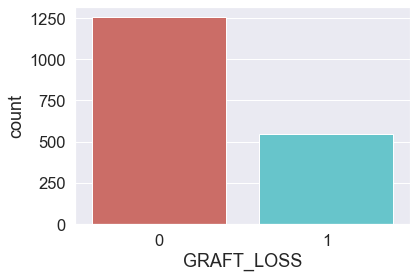

In [8]:
#Impute with the median
df_imp = filter_missing.fillna(filter_missing.median())

df_imp

sns.set(font_scale=1.5)
countplt=sns.countplot(x='GRAFT_LOSS', data=df_imp, palette ='hls')
plt.show()


# Prepare Data with Test Train Split

In [9]:
covariate_list = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','SLINODS_High Dose or Multiple IV','TXSTAT_1A','DONISCH']

#select a few
cols = [col for col in df_imp.columns if col in covariate_list]
                 
#Every column incase teting
cols_all = [col for col in df_imp.columns if col not in ['GRAFT_LOSS','PATIENT_ID','INT_GRAFT_LOSS','SV_GROUP','CHD_HLH','CHD_TRIAT','CHD_DILV']]

data = df_imp[cols]

#I ran a model just to see the scores for all covariates - it was roughly the same which surprised me
data_all = df_imp[cols_all]

print("Percent Missing for Features Included in Model")
print(missing(filter_missing[covariate_list]))
#The predictor
target = df_imp['GRAFT_LOSS']

#Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data,target, test_size = 0.3)

#Print dimensions
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)



Percent Missing for Features Included in Model
LCREAT_R                            18.75
BSA_DONOR                            3.99
BSA_TXPL                             2.94
DONISCH                              2.38
TXCREAT_R                            1.22
SLECMO                               0.61
TXIVINO                              0.39
TXSTAT_1A                            0.00
SLINODS_High Dose or Multiple IV     0.00
DONORSEX_F                           0.00
RRACE_B                              0.00
STATUS_TXPL_Priority                 0.00
SEX_F                                0.00
AGE_TXPL                             0.00
AGE_LISTING                          0.00
dtype: float64
None
(1262, 15)
(541, 15)
(1262,)
(541,)


In [10]:
#Altering this to display mutual information because there are negative values in age so chisq cannot be d
class SelectKBestCustom(SelectKBest):

    # Changed here
    def fit(self, X, y, discrete_features='auto'):
        X, y = check_X_y(X, y, ['csr', 'csc'], multi_output=True)

        if not callable(self.score_func):
            raise TypeError("The score function should be a callable, %s (%s) "
                        "was passed."
                        % (self.score_func, type(self.score_func)))

        self._check_params(X, y)

        # Changed here also
        score_func_ret = self.score_func(X, y, discrete_features)
        if isinstance(score_func_ret, (list, tuple)):
            self.scores_, self.pvalues_ = score_func_ret
            self.pvalues_ = np.asarray(self.pvalues_)
        else:
            self.scores_ = score_func_ret
            self.pvalues_ = None

        self.scores_ = np.asarray(self.scores_)
        return self



bestfeatures = SelectKBest(mutual_info_classif, k=10)
fit = bestfeatures.fit(data_all,target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_all.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features



                                                Specs     Score
97                 LSRHFCL_T_Assessment not Completed  0.036185
67                                          TXCREAT_R  0.030260
58                                        HEIGHT_TXPL  0.024258
87                             STATUS_LISTING_Routine  0.023779
6                                               HXCPR  0.022899
18                                              HXMED  0.019856
83                                           TXSTAT_2  0.019171
90                  LSNYHA_T_Assessment not Completed  0.018031
72                                        STATLIST_1B  0.017502
35                                            CHD_TOF  0.017341
14                                            HXTRANS  0.017253
99  LSRHFCL_T_Class II: Mild tachypnea and/or diap...  0.017048
50                                            DONISCH  0.016475
63                                       WEIGHT_DONOR  0.015798
65                                      

# Decision Tree

In [11]:
dt = DecisionTreeClassifier()

def modelPrediction(model,data_train,target_train,target_test,data_test,model_name,data_all,target_all):
    pred = model.fit(data_train, target_train).predict(data_test)
    Accuracy = accuracy_score(target_test, pred)
    f1 = f1_score(target_test, pred, average='weighted')
    precision = precision_score(target_test, pred, average="weighted")
    recall = recall_score(target_test, pred, average="weighted")   
    AUC = roc_auc_score(target_test, pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(target_test, pred).ravel()
    pd.options.display.float_format = '{:,.3f}'.format
    results = pd.DataFrame(
    {
    'Model Name': [model_name],
    'Accuracy': [Accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC': [AUC],
    'True Negative': [tn],
    'False Positive': [fp],
    'False Negative': [fn],
    'True Positive': [tp],
    })
    return results.stack()

print(modelPrediction(dt,X_train,Y_train,Y_test,X_test,"Decision Tree",data,target))


0  Model Name        Decision Tree
   Accuracy                  0.586
   Precision                 0.592
   Recall                    0.586
   F1 Score                  0.589
   AUC                       0.515
   True Negative               262
   False Positive              116
   False Negative              108
   True Positive                55
dtype: object


# XG Boost

In [12]:
xg = XGBClassifier()

print(modelPrediction(xg,X_train,Y_train,Y_test,X_test,"XG Boost",data,target))

0  Model Name        XG Boost
   Accuracy             0.689
   Precision            0.627
   Recall               0.689
   F1 Score             0.616
   AUC                  0.523
   True Negative          356
   False Positive          22
   False Negative         146
   True Positive           17
dtype: object


# SVC 

In [13]:
svc_model = SVC(kernel='linear')

print(modelPrediction(svc_model,X_train,Y_train,Y_test,X_test,"SVM",data,target))


0  Model Name         SVM
   Accuracy         0.699
   Precision        0.488
   Recall           0.699
   F1 Score         0.575
   AUC              0.500
   True Negative      378
   False Positive       0
   False Negative     163
   True Positive        0
dtype: object


# Logistic Regression

In [14]:
logit = LogisticRegression()

print(modelPrediction(logit,X_train,Y_train,Y_test,X_test,"Logisitc Regression",data,target))

0  Model Name        Logisitc Regression
   Accuracy                        0.691
   Precision                       0.617
   Recall                          0.691
   F1 Score                        0.601
   AUC                             0.512
   True Negative                     364
   False Positive                     14
   False Negative                    153
   True Positive                      10
dtype: object


# Adding first text field - SURGERY HISTORY USING TF-IDF

In [15]:
df_model2 = df_filtered_list.drop(['SPECOTH', 'CHD_OTHSP'], axis = 1) 

#New covariate list with first text field added
covariate_list_txt = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','LSRHFCL_T_Not Done: Too Sick','TXSTAT_1A','DONISCH','SURGERY_HISTORY','GRAFT_LOSS']

#Add these columns
cols2 = [col for col in df_model2.columns if col in covariate_list_txt]

#Every column incase teting
cols_temp2 = [col for col in df_model2.columns if col not in ['PATIENT_ID','INT_GRAFT_LOSS','SV_GROUP','CHD_HLH','CHD_TRIAT','CHD_DILV']]

#All but predictor
df_model2 = df_model2[cols2]

#Remove punctuation
df_model2["SURG_NO_PUNC"] = df_model2['SURGERY_HISTORY'].str.replace('[^\w\s]','')

#Drop CHD_OTHSP because I created CHD_NO_PUNC
df_model_drop = df_model2.drop('SURGERY_HISTORY',axis=1)

#Changed all blanks to missing
df_model_drop['SURG_NO_PUNC'].fillna('', inplace=True)

tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',tokenizer=word_tokenize)
score = tfidf.fit_transform(df_model_drop['SURG_NO_PUNC'])

df = pd.DataFrame(score.toarray(), columns=tfidf.get_feature_names())

df_model_drop = df_model_drop.drop('SURG_NO_PUNC',axis=1)

df_fin = pd.concat([df_model_drop.reset_index(drop=True),df.reset_index(drop=True)], axis=1)

print(df_fin['GRAFT_LOSS'].value_counts())

df_fin

0    1257
1     546
Name: GRAFT_LOSS, dtype: int64


,AGE_LISTING,AGE_TXPL,SLECMO,RRACE_B,TXIVINO,DONISCH,BSA_TXPL,BSA_DONOR,LCREAT_R,TXCREAT_R,...,unicuspid,v,valve,valvotomy,valvuloplasty,vein,veins,vessels,vsd,wautologous
0,0.723,1.136,0.000,0.000,0.000,285.000,0.436,0.366,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,4.893,5.098,0.000,0.000,0.000,262.000,0.646,0.664,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.008,0.041,0.000,0.000,1.000,355.000,0.243,0.261,0.900,0.800,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.533,2.538,1.000,0.000,1.000,185.000,0.496,0.519,0.300,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.068,0.134,0.000,0.000,0.000,332.000,0.245,0.205,0.300,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,1.092,1.484,0.000,0.000,1.000,167.000,0.535,0.725,0.400,0.200,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1799,2.283,2.431,0.000,0.000,1.000,246.000,0.476,0.969,0.300,0.240,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1800,14.002,14.147,0.000,0.000,1.000,366.000,1.758,1.917,0.700,1.100,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1801,3.023,3.910,0.000,0.000,1.000,263.000,0.627,0.807,nan,0.340,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [16]:
#Impute with the median
df_imp2 = df_fin.fillna(df_fin.median())

#Select all but predictor
first_text = [col for col in df_imp2.columns if col not in ['GRAFT_LOSS']]

#If we only want to look at JUST the text, no continuous features
only_text = [col for col in df_imp2.columns if col not in covariate_list_txt]

#The data with all columns but target
data_2 = df_imp2[first_text]

#The data with all columns but target
data_2_ot = df_imp2[only_text]

#The predictor
target_2 = df_imp2['GRAFT_LOSS']

#Split the data
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(data_2,target_2, test_size = 0.3)

#Print dimensions
print(X_train_2.shape)
print(X_test_2.shape)
print(Y_train_2.shape)
print(Y_test_2.shape)

print(X_train_2.columns.values.tolist())

(1262, 223)
(541, 223)
(1262,)
(541,)
['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority', 'LSRHFCL_T_Not Done: Too Sick', '1', '17', '17l', '17pda', '18', '19', '2', '20', '4', '40', '4mm', '5', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'bana', 'band', 'banding', 'bands', 'bcps', 'bdg', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'campr', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coa', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'completion', 'conduit', 'congenitally', 'connect', 'coronary', 'corrected', 'cortex', 'damus', 'debanding', 'defect', 'dilation', 'division', 'divisionat', 'dks', 'do

# Continuous Features + Surgery History Text

In [17]:
print(modelPrediction(logit,X_train_2,Y_train_2,Y_test_2,X_test_2,"Logistic Regression",data_2,target_2))
print(modelPrediction(svc_model,X_train_2,Y_train_2,Y_test_2,X_test_2,"SVM",data_2,target_2))
print(modelPrediction(dt,X_train_2,Y_train_2,Y_test_2,X_test_2,"Decision Tree",data_2,target_2))
print(modelPrediction(xg,X_train_2,Y_train_2,Y_test_2,X_test_2,"XG Boost",data_2,target_2))

0  Model Name        Logistic Regression
   Accuracy                        0.693
   Precision                       0.632
   Recall                          0.693
   F1 Score                        0.614
   AUC                             0.522
   True Negative                     360
   False Positive                     18
   False Negative                    148
   True Positive                      15
dtype: object
0  Model Name         SVM
   Accuracy         0.695
   Precision        0.487
   Recall           0.695
   F1 Score         0.573
   AUC              0.497
   True Negative      376
   False Positive       2
   False Negative     163
   True Positive        0
dtype: object
0  Model Name        Decision Tree
   Accuracy                  0.593
   Precision                 0.615
   Recall                    0.593
   F1 Score                  0.603
   AUC                       0.545
   True Negative               252
   False Positive              126
   False Negative     

# Just Surgery History Text

In [18]:
#Split the data
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(data_2_ot,target_2, test_size = 0.3)

#Print dimensions
print(X_train_2.shape)
print(X_test_2.shape)
print(Y_train_2.shape)
print(Y_test_2.shape)

print(X_train_2.columns.values.tolist())

print(modelPrediction(logit,X_train_2,Y_train_2,Y_test_2,X_test_2,"Logistic Regression",data_2,target_2))
print(modelPrediction(svc_model,X_train_2,Y_train_2,Y_test_2,X_test_2,"SVM",data_2,target_2))
print(modelPrediction(dt,X_train_2,Y_train_2,Y_test_2,X_test_2,"Decision Tree",data_2,target_2))
print(modelPrediction(xg,X_train_2,Y_train_2,Y_test_2,X_test_2,"XG Boost",data_2,target_2))

(1262, 208)
(541, 208)
(1262,)
(541,)
['1', '17', '17l', '17pda', '18', '19', '2', '20', '4', '40', '4mm', '5', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'bana', 'band', 'banding', 'bands', 'bcps', 'bdg', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'campr', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coa', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'completion', 'conduit', 'congenitally', 'connect', 'coronary', 'corrected', 'cortex', 'damus', 'debanding', 'defect', 'dilation', 'division', 'divisionat', 'dks', 'double', 'drainage', 'dtransposition', 'ductal', 'ebsteins', 'ecmo', 'enlargement', 'epicardial', 'fenestration', 'fluid', 'fontan', 'foramen', 'form', 'g', 'glenn', 'great', 'heart', 'hemi', 'hemifontan', 'hemifon

# ADD CHD_OTHSP

In [19]:
#New covariate list with first text field added
covariate_list_txt = ['CHD_OTHSP']

#Add these columns
cols2 = [col for col in df_filtered_list.columns if col in covariate_list_txt]

df_model3 = df_filtered_list[cols2]

df_model3

#Remove punctuation
df_model3["CHD_NO_PUNC"] = df_model3['CHD_OTHSP'].str.replace('[^\w\s]','')

#Drop CHD_OTHSP because I created CHD_NO_PUNC
df_model_drop2 = df_model3.drop('CHD_OTHSP',axis=1)

#Changed all blanks to missing
df_model_drop2['CHD_NO_PUNC'].fillna('', inplace=True)

tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',tokenizer=word_tokenize)
score = tfidf.fit_transform(df_model_drop2['CHD_NO_PUNC'])

# New data frame containing the tfidf features and their scores
df2 = pd.DataFrame(score.toarray(), columns=tfidf.get_feature_names())

df_fin2 = pd.concat([df_imp2.reset_index(drop=True),df2.reset_index(drop=True)], axis=1)

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_fin2['GRAFT_LOSS'].value_counts())

df_fin2

0    1257
1     546
Name: GRAFT_LOSS, dtype: int64


,AGE_LISTING,AGE_TXPL,SLECMO,RRACE_B,TXIVINO,DONISCH,BSA_TXPL,BSA_DONOR,LCREAT_R,TXCREAT_R,...,vena,venous,ventricl,ventricle,ventricles,ventricusee,vsd,w,wiht,wventricular
0,0.723,1.136,0.000,0.000,0.000,285.000,0.436,0.366,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,4.893,5.098,0.000,0.000,0.000,262.000,0.646,0.664,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.008,0.041,0.000,0.000,1.000,355.000,0.243,0.261,0.900,0.800,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.533,2.538,1.000,0.000,1.000,185.000,0.496,0.519,0.300,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.068,0.134,0.000,0.000,0.000,332.000,0.245,0.205,0.300,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,1.092,1.484,0.000,0.000,1.000,167.000,0.535,0.725,0.400,0.200,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1799,2.283,2.431,0.000,0.000,1.000,246.000,0.476,0.969,0.300,0.240,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1800,14.002,14.147,0.000,0.000,1.000,366.000,1.758,1.917,0.700,1.100,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1801,3.023,3.910,0.000,0.000,1.000,263.000,0.627,0.807,0.500,0.340,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [20]:
df_imp3 = df_fin2

df_imp3 = df_imp3.loc[:,~df_imp3.columns.duplicated()]

first_text = [col for col in df_imp3.columns if col not in ['GRAFT_LOSS']]
only_text = [col for col in df_imp3.columns if col not in ['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'HXMED', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'GRAFT_LOSS', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority','LSRHFCL_T_Not Done: Too Sick']]

#The data with all columns but target
data_3 = df_imp3[first_text]

#The predictor
target_3 = df_imp3['GRAFT_LOSS']

#Split the data
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(data_3,target_3, test_size = 0.3)

#Print dimensions
print(X_train_3.shape)
print(X_test_3.shape)
print(Y_train_3.shape)
print(Y_test_3.shape)

print(X_train_3.columns.values.tolist())


(1262, 397)
(541, 397)
(1262,)
(541,)
['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority', 'LSRHFCL_T_Not Done: Too Sick', '1', '17', '17l', '17pda', '18', '19', '2', '20', '4', '40', '4mm', '5', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'bana', 'band', 'banding', 'bands', 'bcps', 'bdg', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'campr', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coa', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'completion', 'conduit', 'congenitally', 'connect', 'coronary', 'corrected', 'cortex', 'damus', 'debanding', 'defect', 'dilation', 'division', 'divisionat', 'dks', 'do

In [21]:
print(modelPrediction(logit,X_train_3,Y_train_3,Y_test_3,X_test_3,"Logistic Regression",data_3,target_3))

print(modelPrediction(dt,X_train_3,Y_train_3,Y_test_3,X_test_3,"Decision Tree",data_3,target_3))

print(modelPrediction(svc_model,X_train_3,Y_train_3,Y_test_3,X_test_3,"SVM",data_3,target_3))

print(modelPrediction(xg,X_train_3,Y_train_3,Y_test_3,X_test_3,"XG Boost",data_3,target_3))

0  Model Name        Logistic Regression
   Accuracy                        0.708
   Precision                       0.678
   Recall                          0.708
   F1 Score                        0.631
   AUC                             0.541
   True Negative                     364
   False Positive                     13
   False Negative                    145
   True Positive                      19
dtype: object
0  Model Name        Decision Tree
   Accuracy                  0.634
   Precision                 0.634
   Recall                    0.634
   F1 Score                  0.634
   AUC                       0.567
   True Negative               278
   False Positive               99
   False Negative               99
   True Positive                65
dtype: object
0  Model Name         SVM
   Accuracy         0.697
   Precision        0.486
   Recall           0.697
   F1 Score         0.572
   AUC              0.500
   True Negative      377
   False Positive       0
   F

# Only text fields

In [22]:
#The data with all columns but target
data_3 = df_imp3[only_text]

#The predictor
target_3 = df_imp3['GRAFT_LOSS']

#Split the data
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(data_3,target_3, test_size = 0.3)

#Print dimensions
print(X_train_3.shape)
print(X_test_3.shape)
print(Y_train_3.shape)
print(Y_test_3.shape)

print(X_train_3.columns.values.tolist())

print(modelPrediction(logit,X_train_3,Y_train_3,Y_test_3,X_test_3,"Logistic Regression",data_3,target_3))

print(modelPrediction(dt,X_train_3,Y_train_3,Y_test_3,X_test_3,"Decision Tree",data_3,target_3))

print(modelPrediction(svc_model,X_train_3,Y_train_3,Y_test_3,X_test_3,"SVM",data_3,target_3))

print(modelPrediction(xg,X_train_3,Y_train_3,Y_test_3,X_test_3,"XG Boost",data_3,target_3))

(1262, 382)
(541, 382)
(1262,)
(541,)
['1', '17', '17l', '17pda', '18', '19', '2', '20', '4', '40', '4mm', '5', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'bana', 'band', 'banding', 'bands', 'bcps', 'bdg', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'campr', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coa', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'completion', 'conduit', 'congenitally', 'connect', 'coronary', 'corrected', 'cortex', 'damus', 'debanding', 'defect', 'dilation', 'division', 'divisionat', 'dks', 'double', 'drainage', 'dtransposition', 'ductal', 'ebsteins', 'ecmo', 'enlargement', 'epicardial', 'fenestration', 'fluid', 'fontan', 'foramen', 'form', 'g', 'glenn', 'great', 'heart', 'hemi', 'hemifontan', 'hemifon